In [3]:
%matplotlib inline
import seaborn as sbn
sbn.set_style('white')
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from machinedesign.autoencoder.interface import _apply_noise, _apply_binarization
from keras.models import Model
from keras.layers import InputLayer
from keras import backend as K
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import math
from collections import defaultdict
from scipy.spatial.distance import cdist
from lapjv import lapjv

Using Theano backend.


In [4]:
dataset = '../../data/digits.npz'
data = np.load(dataset)
X = data['X']
y = data['y'] if 'y' in data else None
X = X.astype(np.float32)
X /= 255.

In [5]:
folder = '../results/jobs/ab45d34bd45790c492f913e11f28b1dd//'

In [6]:
model = load('../results/{}'.format(folder))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 24, 24)       3328      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 24, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 20, 20)       409728    
_________________________________________________________________
activation_2 (Activation)    (None, 128, 20, 20)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        51216     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 16)        0         
__________

In [9]:
#mnist
inp = model.layers[0].input
hid_layer = model.get_layer('winner_take_all_channel_1')
hid = hid_layer.output
out = model.layers[-1].output
enc = K.function([inp], hid)
dec = K.function([hid], out)

In [10]:
#mnist
inp = model.layers[0].input
hid_layer = model.get_layer('winner_take_all_spatial_1')
hid = hid_layer.output
out = model.layers[-1].output
enc = K.function([inp], hid)
dec = K.function([hid], out)

In [ ]:
# *_dense_*
inp = model.layers[0].input
hid_layer = model.get_layer('activation_4')
hid = hid_layer.output
out = model.layers[-1].output
enc = K.function([inp], hid)
dec = K.function([hid], out)

In [ ]:
# *_dcgan_*
inp = model.layers[0].input
hid_layer = model.get_layer('activation_4')
hid = hid_layer.output
out = model.layers[-1].output
enc = K.function([inp], hid)
dec = K.function([hid], out)

In [91]:
# *_vertebrate_* or *_vertebrate_deep_*
inp_layers = [ 
    model.get_layer('winner_take_all_spatial_1'),
    model.get_layer('winner_take_all_spatial_2'),
    model.get_layer('winner_take_all_spatial_3'),
]
inp = [l.output for l in inp_layers]
out = [
    model.get_layer('activation_4').output,
    model.get_layer('activation_5').output,
    model.get_layer('activation_6').output,
    model.get_layer('activation_7').output
]
decs = K.function(inp, out)
dec = K.function(inp, model.get_layer('activation_7').output)
enc = K.function([model.layers[0].input], inp)

In [ ]:
# _deep2
inp_layers = [ 
    model.get_layer('winner_take_all_spatial_1'),
    model.get_layer('winner_take_all_spatial_2'),
    model.get_layer('winner_take_all_spatial_3'),
    model.get_layer('winner_take_all_spatial_4'),
]
inp = [l.output for l in inp_layers]
out = [
    model.get_layer('activation_5').output,
    model.get_layer('activation_7').output,
    model.get_layer('activation_10').output,
    model.get_layer('activation_14').output,
    model.get_layer('activation_15').output
]
decs = K.function(inp, out)
dec = K.function(inp, model.get_layer('activation_10').output)
enc = K.function([model.layers[0].input], inp)

In [ ]:
# _deep3
inp_layers = [ 
    model.get_layer('winner_take_all_spatial_1'),
    model.get_layer('winner_take_all_spatial_2'),
    model.get_layer('winner_take_all_spatial_3'),
    model.get_layer('winner_take_all_spatial_4'),
]
inp = [l.output for l in inp_layers]
out = [
    model.get_layer('activation_5').output,
    model.get_layer('activation_6').output,
    model.get_layer('activation_7').output,
    model.get_layer('activation_8').output,
    model.get_layer('activation_9').output
]
decs = K.function(inp, out)
dec = K.function(inp, model.get_layer('activation_9').output)
enc = K.function([model.layers[0].input], inp)

In [92]:
# *_vertebrate
H = [np.zeros((layer.input_shape[1],) + layer.input_shape[1:]) for layer in inp_layers]
ind = np.arange(inp_layers[0].input_shape[1])
for h in H:
    print(h.shape)
IDX = 2
H[IDX][ind, ind, 2, 2] = 100.0
outs = decs(H)
im = grid_of_images_default(outs[IDX], normalize=True)
imsave('../results/{}/features.png'.format(folder), im)

(64, 64, 24, 24)
(64, 64, 20, 20)
(64, 64, 16, 16)


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [ ]:
# *_vertebrate
H = [np.zeros((layer.input_shape[1],) + layer.input_shape[1:]) for layer in inp_layers]
ind = np.arange(inp_layers[0].input_shape[1])
for h in H:
    print(h.shape)
IDX = 0
H[IDX][ind, ind, 2, 2] = 100.0
out = dec(H)
im = grid_of_images_default(out, normalize=True)
imsave('../results/{}/features.png'.format(folder), im)

In [20]:
H = np.zeros((16,) + hid_layer.input_shape[1:])
H[np.arange(H.shape[0]), np.arange(H.shape[0]), 8, 8] = 30.0
x  = dec([H])
im = grid_of_images_default(x, normalize=True)
imsave('out.png'.format(folder), im)

/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [13]:
H = enc([X[0:9]])
print(H.shape)
#H[:, 99]=0.
#H[:, 62]=0.
#H[:, 106]=0.
#H[:, 86]=0.
x  = dec([H])
im = grid_of_images_default(x, normalize=True)
imsave("out.png", im)

(9, 16, 16, 16)


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [14]:
# reconstruction
x = X[2:3]
h = enc([x])
o = decs(h)
o = np.concatenate([x]+o, axis=0)
print(o.shape)
print(folder)
im = grid_of_images_default(o, normalize=True)
imsave('out.png', im)

NameError: name 'decs' is not defined

In [10]:
clf = load('../../discr/digits')
clf_enc = Model(inputs=clf.layers[0].input, outputs=clf.get_layer('p_re_lu_4').output)
#clf_enc = Model(inputs=clf.layers[0].input, outputs=clf.layers[0].output)

In [19]:
def featurize(h):
    mask = (h==h.max(axis=(2,3), keepdims=True))
    xx, yy = np.indices((h.shape[2], h.shape[3]))
    xx = xx / xx.max()
    yy = yy / yy.max()
    xx = xx.reshape((1, 1, xx.shape[0], xx.shape[1]))
    yy = yy.reshape((1, 1, yy.shape[0], yy.shape[1]))
    x = (mask * xx).max(axis=(2, 3))
    y = (mask * yy).max(axis=(2, 3))
    print(x.shape, y.shape)
    return np.concatenate((x, y), axis=1)
gen = np.load('../results/{}/gen/generated.npz'.format(folder))
nb_gen = 1000
Xgen = gen['generated'][0:nb_gen]
hgen = featurize(enc([Xgen]))

Xtrue = X[0:nb_gen]
htrue = featurize(enc([Xtrue]))

(1000, 16) (1000, 16)
(1000, 16) (1000, 16)


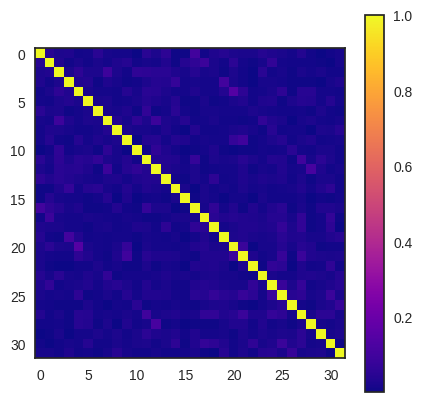

In [35]:
# Computes normalized mutual information between all possible pairs of features
#ind = np.arange(hgen.shape[1]//2, hgen.shape[1])
#np.random.shuffle(ind)
#ind = np.arange(hgen.shape[1])
ind = np.arange(0, 32)
h_ = htrue[:, ind]
m = np.zeros((h_.shape[1], h_.shape[1]))
for i in range(h_.shape[1]):
    for j in range(i, h_.shape[1]):
        ij_counts = defaultdict(int)
        icounts = defaultdict(int)
        jcounts = defaultdict(int)
        for k in range(len(h_)):
            ij_counts[(h_[k, i], h_[k, j])] += 1
            icounts[h_[k, i]] += 1
            jcounts[h_[k, j]] += 1
        ij_total = sum(ij_counts.values())
        i_total = sum(icounts.values())
        j_total = sum(jcounts.values())
        m[i, j] = 0.
        for (vi, vj), nb in ij_counts.items():
            pij = nb / ij_total
            pi = icounts[vi] / i_total
            pj = jcounts[vj] / j_total
            m[i, j] += pij * math.log(pij / (pi * pj))
        hi = sum((nb/i_total) * math.log(nb/i_total) for nb in icounts.values())
        hj = sum((nb/j_total) * math.log(nb/j_total) for nb in jcounts.values())
        m[i, j] /= math.sqrt(hi * hj)
        m[j, i] = m[i, j]
fig = plt.figure(figsize=(5, 5))
plt.imshow(m, cmap='plasma')
plt.colorbar()
